# 复现论文中的公式（2）和公式（3）

验证公式（3）为什么能够让擅长某Case的专家更快地拟合。

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [25]:

# 定义专家网络（Expert Network）
class Expert(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Expert, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # 第一层全连接层
        self.relu = nn.ReLU()  # ReLU激活函数
        self.fc2 = nn.Linear(hidden_size, output_size)  # 第二层全连接层

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 定义门控网络（Gating Network）
class GatingNetwork(nn.Module):
    def __init__(self, input_size, num_experts):
        super(GatingNetwork, self).__init__()
        self.fc = nn.Linear(input_size, num_experts)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        return self.softmax(self.fc(x))

# 定义混合模型（Mixture of Experts Model）
class MoE(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_experts):
        super(MoE, self).__init__()
        self.gating_network = GatingNetwork(input_size, num_experts)
        self.experts = nn.ModuleList([Expert(input_size, hidden_size, output_size) for _ in range(num_experts)])

    def forward(self, x):
        batch_size = x.size(0)
        
        # 获取门控网络的输出
        gates = self.gating_network(x)  # [batch_size, num_experts]
        
        # 获取所有专家网络的输出
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)  # [batch_size, num_experts, output_size]
        
        # 对专家网络的输出进行加权求和
        # gates: [batch_size, num_experts] -> [batch_size, num_experts, 1] 用于与 expert_outputs 相乘
        gates = gates.unsqueeze(-1)  # [batch_size, num_experts, 1]
        
        # 加权求和专家输出
        # output = torch.sum(gates * expert_outputs, dim=1)  # [batch_size, output_size]
        
        return gates, expert_outputs 

# 示例使用
# if __name__ == "__main__":
#     input_size = 10
#     hidden_size = 20
#     output_size = 5
#     num_experts = 3
#     batch_size = 4

#     # 创建模型
#     model = MoE(input_size, hidden_size, output_size, num_experts)

#     # 随机生成输入数据
#     x = torch.randn(batch_size, input_size)

#     # 前向传播
#     output = model(x)
#     print(output.shape)  # 应该输出 [batch_size, output_size]，即 [4, 5]


In [26]:
# 定义两种误差函数
def error_func_2(expert_outputs, targets, probabilities):
    # 使用 MSE 作为损失
    mse_loss = torch.sum(probabilities * (targets.unsqueeze(1) - expert_outputs) ** 2, dim=1)
    return torch.mean(mse_loss)

def error_func_3(expert_outputs, targets, probabilities):
    # 使用自定义的 log-sum-exp 损失
    exp_term = torch.exp(-0.5 * (targets.unsqueeze(1) - expert_outputs) ** 2)
    weighted_exp = probabilities * exp_term
    log_sum_exp = -torch.log(torch.sum(weighted_exp, dim=1))
    return torch.mean(log_sum_exp)

In [27]:
# 初始化两个 MoE 模型，确保它们的初始参数是相同的
def initialize_models(input_size, hidden_size, output_size, num_experts, device):
    model_1 = MoE(input_size, hidden_size, output_size, num_experts).to(device)
    model_2 = MoE(input_size, hidden_size, output_size, num_experts).to(device)

    # 将 model_2 的参数设置为与 model_1 相同
    model_2.load_state_dict(model_1.state_dict())
    
    return model_1, model_2

# 数据加载与处理
def load_and_preprocess_data(batch_size, device):
    # 加载加利福尼亚房价数据集
    cali = fetch_california_housing()
    X = cali.data
    y = cali.target

    # 数据标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 将数据集拆分为训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # 转换为 PyTorch 张量
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # 移动张量到GPU
    X_train_tensor = X_train_tensor.to(device)
    y_train_tensor = y_train_tensor.to(device)
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 使用 DataLoader 进行批量加载
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, X_train, X_test, y_train, y_test


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
import requests
url = 'https://example.com/some-restricted'
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
response = requests.get(url, headers=headers)
print(response.status_code)

404


In [30]:
# 模型参数
input_size = 8  # 加利福尼亚房价数据集有8个特征
hidden_size = 16 # 隐藏层大小
output_size = 1  # 输出是房价
num_experts = 3
batch_size = 8

# 加载和处理数据
train_loader, test_loader, X_train, X_test, y_train, y_test = load_and_preprocess_data(batch_size, device)

# 初始化模型
model_1, model_2 = initialize_models(input_size, hidden_size, output_size, num_experts, device)

# 定义优化器（使用相同的优化器配置）
optimizer_1 = optim.SGD(model_1.parameters(), lr=0.1)
optimizer_2 = optim.SGD(model_2.parameters(), lr=0.1)

# 训练参数
epochs = 300
errors_2 = []
errors_3 = []

HTTPError: HTTP Error 403: Forbidden

In [189]:
# 训练循环
for epoch in tqdm(range(epochs)):
    model_1.train()
    model_2.train()
    
    epoch_loss_2 = 0.0
    epoch_loss_3 = 0.0

    for X_batch, y_batch in train_loader:
        # 对 model_1 使用 error_func_2 进行训练
        optimizer_1.zero_grad()
        gates_1, expert_outputs_1 = model_1(X_batch)
        loss_2 = error_func_2(expert_outputs_1, y_batch, gates_1)
        loss_2.backward()
        optimizer_1.step()

        # 对 model_2 使用 error_func_3 进行训练
        optimizer_2.zero_grad()
        gates_2, expert_outputs_2 = model_2(X_batch)
        loss_3 = error_func_3(expert_outputs_2, y_batch, gates_2)
        loss_3.backward()
        optimizer_2.step()

        # 累计每个 batch 的损失
        epoch_loss_2 += loss_2.item()
        epoch_loss_3 += loss_3.item()

    # 记录每个 epoch 的平均损失
    errors_2.append(epoch_loss_2 / len(train_loader))
    errors_3.append(epoch_loss_3 / len(train_loader))

# 绘制损失函数的变化趋势
plt.figure(figsize=(24, 6))
plt.plot(errors_2, label='Loss 2 (Custom MSE)', color='blue')
plt.plot(errors_3, label='Loss 3 (Log-Sum-Exp)', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Comparison: Custom MSE vs Log-Sum-Exp')
plt.grid(True)
plt.show()

  0%|          | 1/300 [00:16<1:22:23, 16.53s/it]


KeyboardInterrupt: 

In [172]:
# 在测试集上评估模型性能并获取预测值
model_1.eval()
model_2.eval()

with torch.no_grad():
    # 模型1的预测
    gates_1_test, expert_outputs_1_test = model_1(X_test)
    predictions_1 = torch.sum(gates_1_test * expert_outputs_1_test, dim=1)
    
    # 模型2的预测
    gates_2_test, expert_outputs_2_test = model_2(X_test)
    predictions_2 = torch.sum(gates_2_test * expert_outputs_2_test, dim=1)

    # 计算测试集损失
    test_loss_2 = error_func_2(expert_outputs_1_test, y_test, gates_1_test)
    test_loss_3 = error_func_3(expert_outputs_2_test, y_test, gates_2_test)

In [173]:
def calculate_mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

In [174]:
# 示例数据
y_true = y_test.squeeze()
y_pred_1 = predictions_1.squeeze()
y_pred_2 = predictions_2.squeeze()

# 计算指标
mse_1 = calculate_mse(y_true, y_pred_1)
mse_2 = calculate_mse(y_true, y_pred_2)
rmse_1 = calculate_rmse(y_true, y_pred_1)
rmse_2 = calculate_rmse(y_true, y_pred_2)
mae_1 = calculate_mae(y_true, y_pred_1)
mae_2 = calculate_mae(y_true, y_pred_2)
# mape_1 = calculate_mape(y_true, y_pred_1)
# mape_2 = calculate_mape(y_true, y_pred_2)
r2_1 = calculate_r2(y_true, y_pred_1)
r2_2 = calculate_r2(y_true, y_pred_2)

print('在测试集上公式（2）和公式（3）的性能指标对比：')
print(f"MSE: {mse_1} vs {mse_2}") # 越小越好
print(f"RMSE: {rmse_1} vs {rmse_2}") # 越小越好
print(f"MAE: {mae_1} vs {mae_2}") # 越小越好
# print(f"MAPE: {mape_1}% vs {mape_2}%") # 越小越好
print(f"R²: {r2_1} vs {r2_2}") # 越接近1越好

ValueError: Input contains NaN.

真实值: [0.1499900072813034, 0.17499999701976776, 0.22499999403953552, 0.28299999237060547, 0.30000001192092896, 0.32499998807907104, 0.32499998807907104, 0.3659999966621399, 0.375, 0.3880000114440918, 0.3959999978542328, 0.42500001192092896, 0.4269999861717224, 0.4309999942779541, 0.4359999895095825, 0.43700000643730164, 0.43799999356269836, 0.4399999976158142, 0.4440000057220459, 0.4440000057220459, 0.44600000977516174, 0.44999998807907104, 0.45500001311302185, 0.45500001311302185, 0.4560000002384186, 0.4580000042915344, 0.46299999952316284, 0.46700000762939453, 0.46799999475479126, 0.4699999988079071, 0.47699999809265137, 0.47999998927116394, 0.48100000619888306, 0.48100000619888306, 0.48500001430511475, 0.4860000014305115, 0.4869999885559082, 0.4880000054836273, 0.49300000071525574, 0.4950000047683716, 0.4959999918937683, 0.49799999594688416, 0.49799999594688416, 0.5, 0.5040000081062317, 0.5049999952316284, 0.5080000162124634, 0.5080000162124634, 0.5090000033378601, 0.5120000243186951

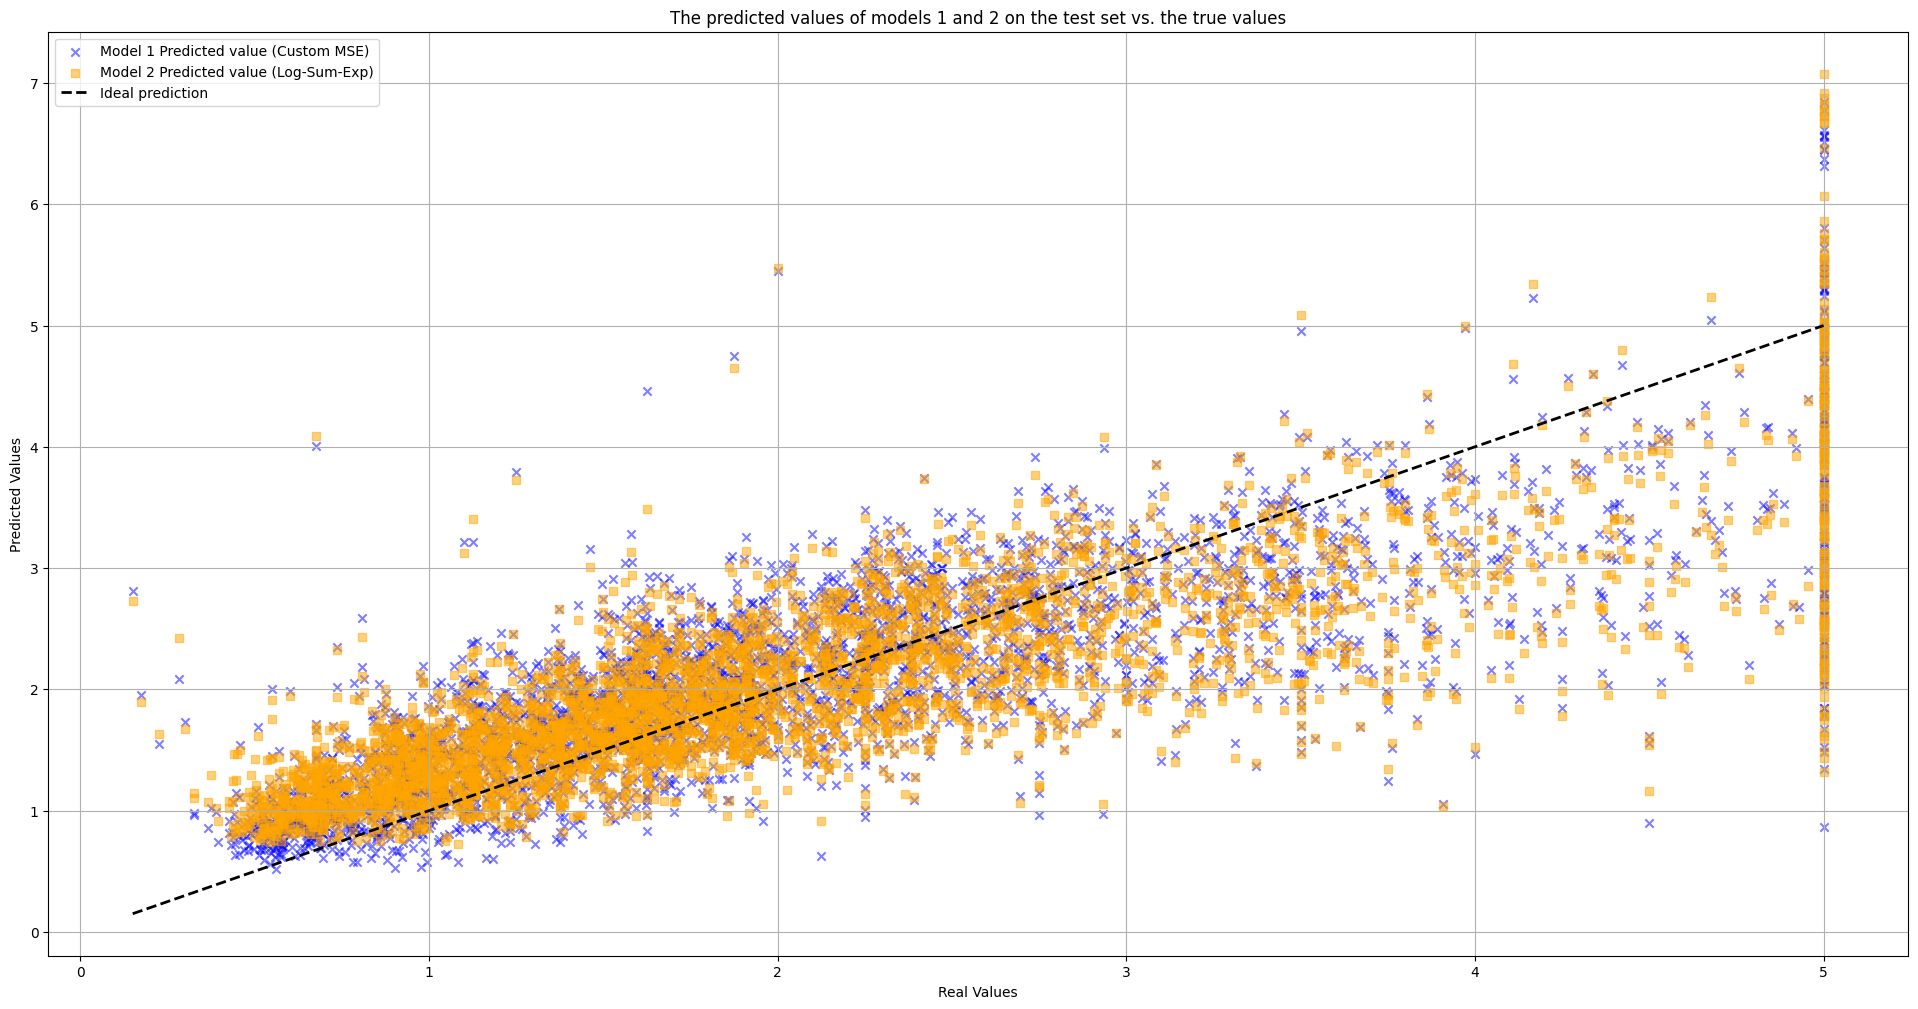

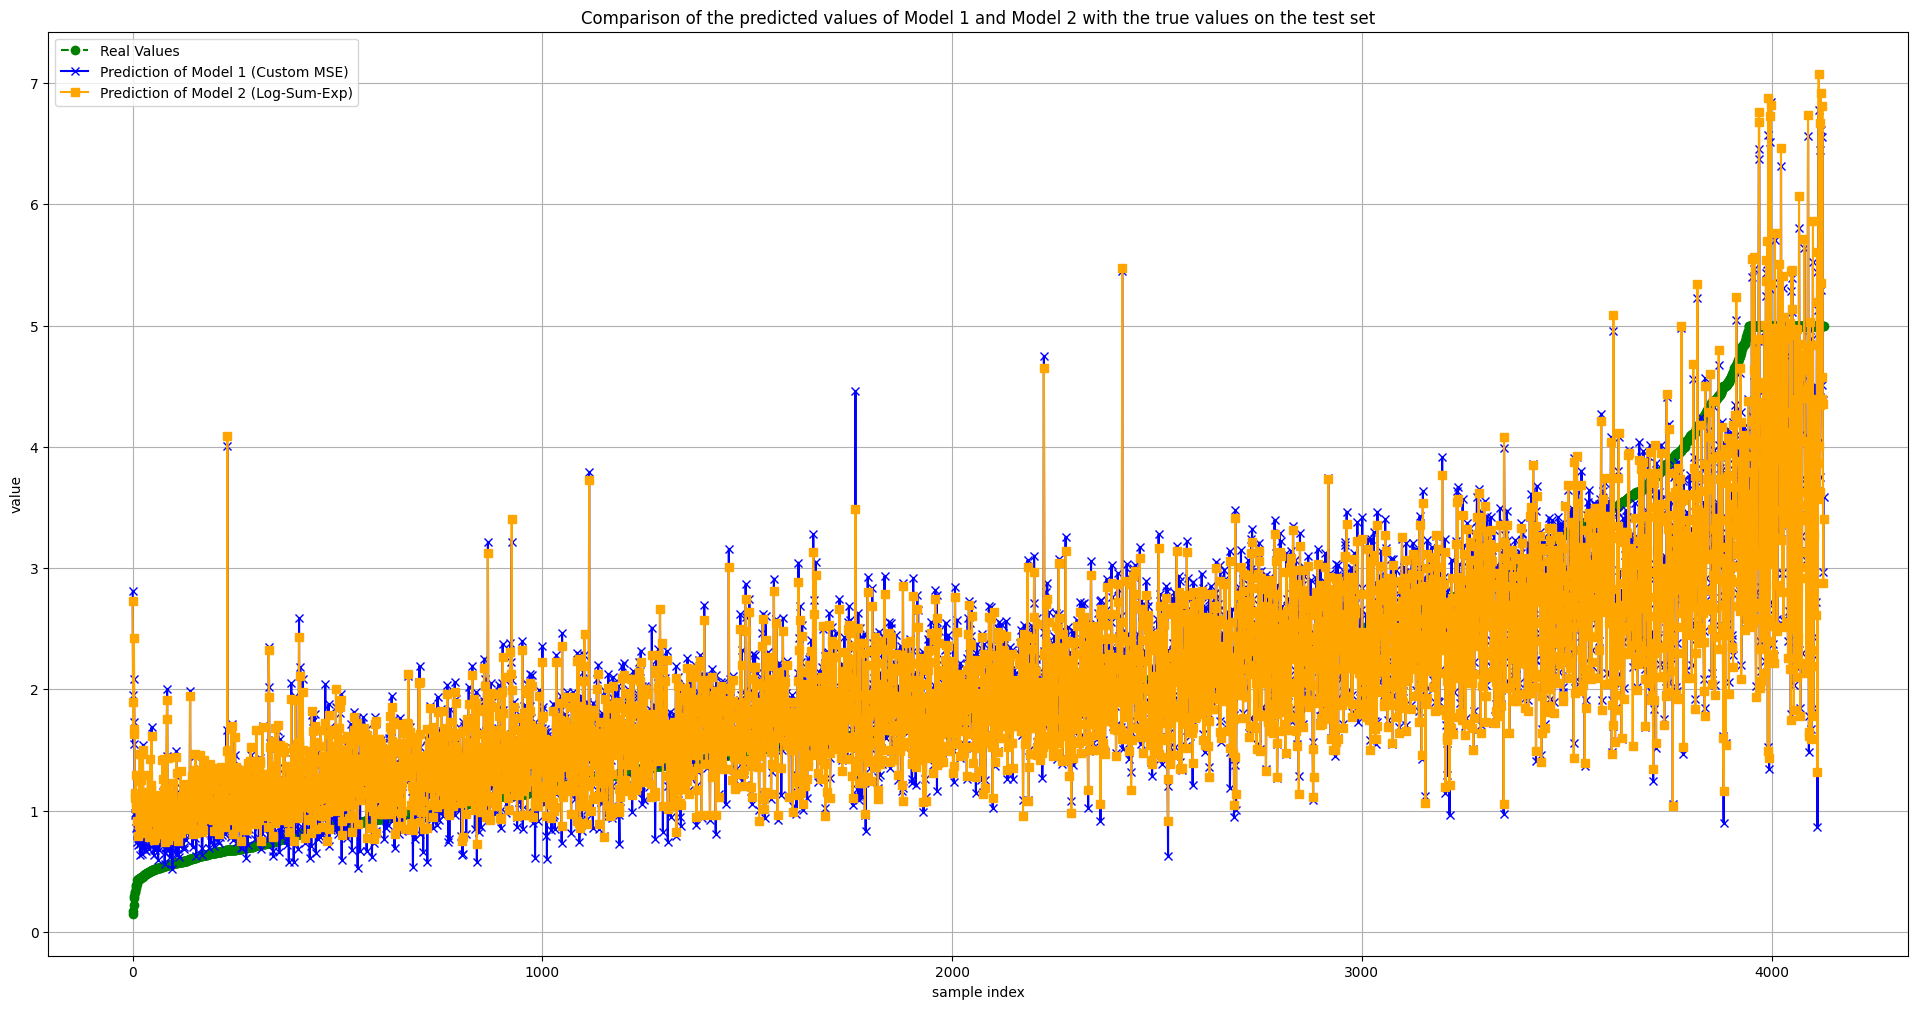

In [148]:
# 将预测值和真实值转换为 NumPy 数组，便于绘图
y_test_np = y_test.squeeze().numpy()
predictions_1_np = predictions_1.squeeze().numpy()
predictions_2_np = predictions_2.squeeze().numpy()

# 可视化1：散点图
plt.figure(figsize=(24, 12))
plt.scatter(y_test_np, predictions_1_np, color='blue', alpha=0.5, label='Model 1 Predicted value (Custom MSE)', marker='x')
plt.scatter(y_test_np, predictions_2_np, color='orange', alpha=0.5, label='Model 2 Predicted value (Log-Sum-Exp)', marker='s')
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'k--', lw=2, label='Ideal prediction')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('The predicted values of models 1 and 2 on the test set vs. the true values')
plt.legend()
plt.grid(True)
plt.show()

# 可视化2：折线图
plt.figure(figsize=(24, 12))
plt.plot(y_test_np, label='Real Values', color='green', linestyle='--', marker='o')
plt.plot(predictions_1_np, label='Prediction of Model 1 (Custom MSE)', color='blue', linestyle='-', marker='x')
plt.plot(predictions_2_np, label='Prediction of Model 2 (Log-Sum-Exp)', color='orange', linestyle='-', marker='s')
plt.xlabel('sample index')
plt.ylabel('value')
plt.title('Comparison of the predicted values of Model 1 and Model 2 with the true values on the test set')
plt.legend()
plt.grid(True)
plt.show()